## Shannon Entropy

정보이론의 아버지로 불리는 Claude Shannon은 엔트로피를 정상성 데이터 소스로부터 생성된 (메세지에 대한) 정보의 평균량으로 정의했다. 이는 고유하게 디코딩하는 방식으로 메세지를 기술하는 데 필요한 글자당 최소 비트의 개수이다. Shannon은 가능한 값 $x \in A$를 갖는 이산 랜덤 변수 $X$의 엔트로피를 다음과 같이 정의했다.

$$H[X] \equiv -\sum_{x \in A} p(x)\log_2 p(x) $$

여기서 $0 \leq H(X) \leq \log_2(\lVert A \rVert)$이고, $p(x)$는 $x$의 확률이다. $H(X) = 0 \Leftrightarrow \exists x | p(X) = 1$, 즉 $p(x) = 1$이 되는 $x$가 존재하고, $H(X) = \log_2(\lVert A \rVert) \Leftrightarrow p(x) = \frac{1}{\lVert A \rVert} \forall x$ 이다. 여기서 $\lVert A \rVert$는 집합 $A$의 크기다. 이는 $X$ 내에 담겨져 있는 정보량의 확률 가중 평균으로 이해할 수 있다. 정보의 비트들은 $\log_2 \frac{1}{p(x)}$로 측정된다. 낮은 확률로 발생하는 결과는 높은 확률로 발생하는 결과보다 더 많은 정보를 갖고 있다는 관측에서 비롯된다. 다시 말해서, 우리는 예상치 못한 일이 발생했을 때 무엇인가를 더 배우기 마련이다. 이와 유사하게 중복성은 다음과 같이 정의된다.

$$R(X) \equiv 1 - \frac{H(X)}{\log_2(\lVert A \rVert)}$$

여기서 $0 \leq R(X) \leq 1$이다. Kologorov는 Markov 정보 소스의 중복성과 복잡도 사이의 연결 관계를 형식화했다. 두 변수 간의 상포 정보는 결합 확률 밀도와 한계 확률 밀도 곱의 Kullback Leibler Divergence로 정의된다.

$$MI(X, Y) = E_{f(x,y)}\left[ \log \frac{f(x,y)}{f(x) f(y)}\right] = H(X) + H(Y) - H(X,Y)$$

Mutual Information은 항상 non-negative이고, 대칭이며, $X$와 $Y$가 서로 독립적인 경우에만 0이다. 정규 분포 변수의 경우 상호 정보는 익숙한 pearson correlation $\rho$와 연관된다.

$$MI(X, Y) = -\frac{1}{2} \log(1 - \rho^2)$$

따라서, Mutual Information은 변수들이 선형이든 비선형이든 연관성을 측정하는 자연스러운 척도이다. 정보의 정규화된 분산은 Mutual Information으로부터 도출된 척도라고 할 수 있다.

### Shannon Entropy for Financial Time Series

금융 시계열에서의 Entropy 적용은 여러 차례 시도되어 왔다. 그중 특정 구간을 Symbol로 변환한 뒤, Shannon Entropy를 추정하는 방법이 가장 많이 연구되고 있다. Joanna Olbryś(2023)는 Symbolic Label의 엔트로피 추정치를 계산한 결과, 특정 기간에 시장의 효율성이 감소하였음을 보였다. 가장 많이 사용되는 방법 중 하나는 Tick Rule과 같이 0을 기점으로 $b \in \{0, 1\}$의 두개의 label로 이진 인코딩을 진행한 뒤 window를 설정하여 Shannon Entropy를 추정하는 것이다. 아래는 그 일련의 과정을 보여준다

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('../../Data/spy_1min_from2020.csv', index_col = 0)
data.index = pd.to_datetime(data.index)

1분 데이터를 사용해 2022년 유동성 회수 기간동안의 엔트로피 변화를 관측해 보자

In [47]:
data['return'] = data['close'].pct_change()

In [48]:
data.loc[data['return'] < 0, 'label'] = 0 # Symbolic labeling
data.loc[data['return'] >= 0, 'label'] = 1

In [49]:
def shannon_entropy(data) :
    values, counts = np.unique(data, return_counts = True)
    probabilities = counts / len(data)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

In [60]:
data['shannon_entropy_30ma'] = data['return'].rolling(window = 30).apply(
    lambda x : shannon_entropy(x)
)
data['shannon_entropy_60ma'] = data['return'].rolling(window = 60).apply(
    lambda x : shannon_entropy(x)
)
data['shannon_entropy_390ma'] = data['return'].rolling(window = 390).apply(
    lambda x : shannon_entropy(x)
)

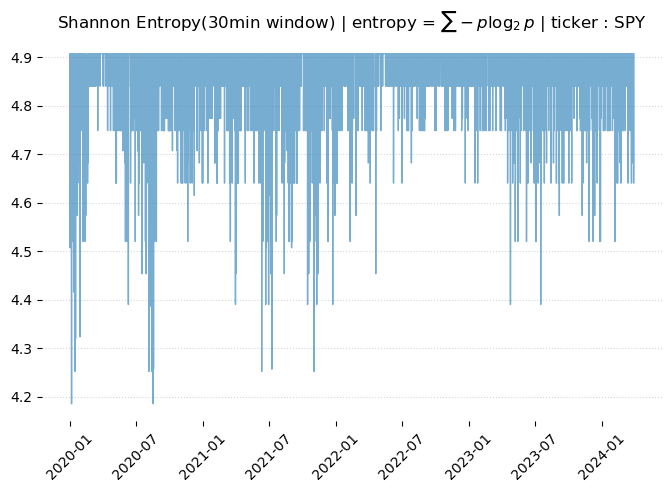

In [56]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    data['shannon_entropy_30ma'].index,
    data['shannon_entropy_30ma'],
    alpha = 0.6,
    lw = 1,
    label = 'entropy'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.xticks(rotation = 45)
plt.title(r'Shannon Entropy(30min window) | entropy = $\sum -p\log_2 p$ | ticker : SPY')
plt.show()

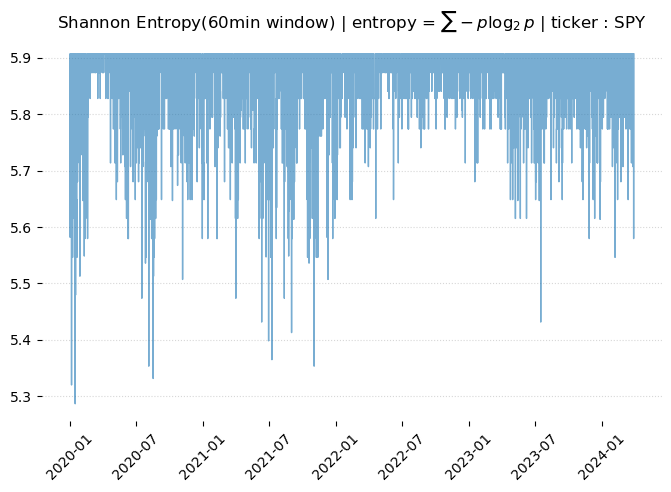

In [57]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    data['shannon_entropy_60ma'].index,
    data['shannon_entropy_60ma'],
    alpha = 0.6,
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.xticks(rotation = 45)
plt.title(r'Shannon Entropy(60min window) | entropy = $\sum -p\log_2 p$ | ticker : SPY')
plt.show()

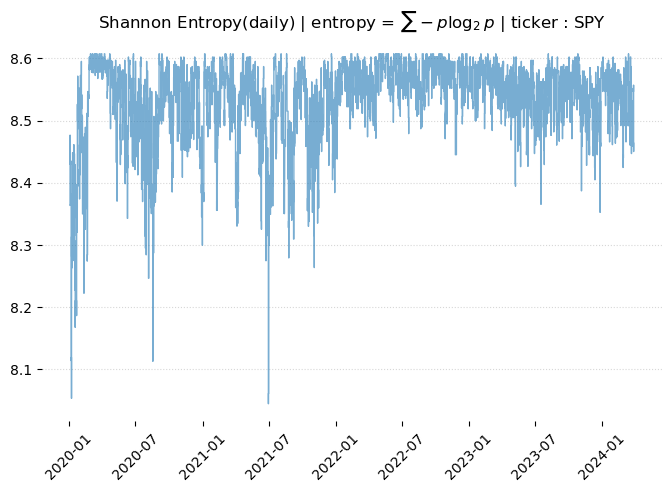

In [61]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    data['shannon_entropy_390ma'].index,
    data['shannon_entropy_390ma'],
    alpha = 0.6,
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 

plt.xticks(rotation = 45)
plt.title(r'Shannon Entropy(daily) | entropy = $\sum -p\log_2 p$ | ticker : SPY')
plt.show()

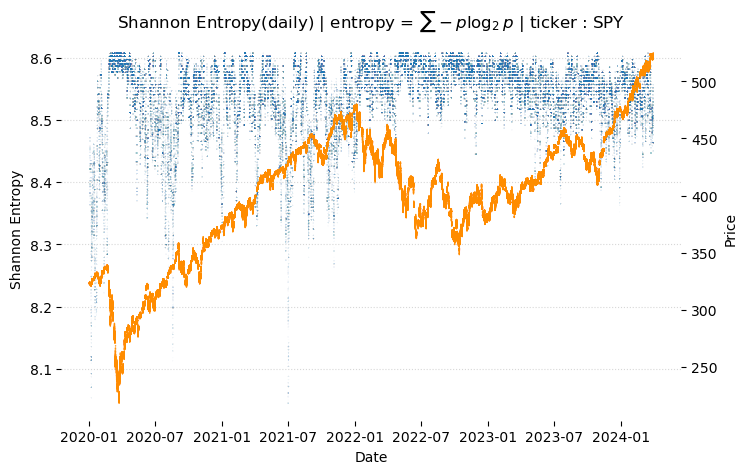

In [77]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.scatter(
    data['shannon_entropy_390ma'].index,
    data['shannon_entropy_390ma'],
    alpha = 0.02,
    s = 4,
    edgecolor = 'none',
    marker = '.'
)
ax1.set_xlabel('Date') 
ax1.set_ylabel('Shannon Entropy') 
ax1.grid(False)
ax1.yaxis.grid(True, ls=':', alpha=0.5)
for spine in ax1.spines.values():
    spine.set_visible(False)

ax2 = ax1.twinx() 
ax2.scatter(
    data['close'].index,
    data['close'],
    color = 'darkorange',
    marker = '.',
    alpha = 0.5,
    s = 4,
    edgecolor = 'none'
)
ax2.set_ylabel('Price') 
for spine in ax2.spines.values():
    spine.set_visible(False)

plt.xticks(rotation = 45)
plt.title(r'Shannon Entropy(daily) | entropy = $\sum -p\log_2 p$ | ticker : SPY')
plt.show()

전체적으로 보았을 때, 가격 게열에서 모멘텀이 관측될 때 엔트로피가 낮아지는 현상을 보인다. 가격에 불확실성이 적어질수록, 즉 시장 참여자가 예측가능한 시장일수록 엔트로피가 적어지는 특성을 볼 수 있다. 반편, 시장이 횡보하거나 약세를 보일 때 불확실성이 증가하여 엔트로피가 높게 관측되는 것을 볼 수 있다.

Entropy 추정량은 Algorithm Trading에 응용될 수 있을 뿐만 아니라, Market regime change에도 유용하게 쓰일 수 있다. 인코딩과 관련된 자세한 사항은 추후 Encoding 파트에서 다룬다